In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# load corpus dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_from_disk
from src.data.create_corpus_dataset import create_dataset
from src.data.classes import UtteranceType, DatasetConfig, Passage, Query, DatasetSplitType
from src.data.dataset_splits import create_splits_from_corpus_dataset
from collections import defaultdict

from src.features.build_features import filter_queries_for_few_shot_setting, filter_passages_for_few_shot_setting, \
    create_dataset_for_multiple_negatives_ranking_loss

# load dataset
dataset_folder = "../../data/processed/with_context"
dataset_path = os.path.join(dataset_folder, "corpus_dataset_v2")

if not os.path.exists(dataset_path):
    # Beispiel zum Erstellen eines Datensatzes. Mögliche Optionen von DatasetConfig sind im DocString beschrieben.
    create_dataset(
        DatasetConfig(
            dataset_path=dataset_path,
            project_dir="../../",
            utterance_type=UtteranceType.User,
            eval_size=0.5,
            validation_test_ratio=0.5
        )
    )

# Beispiel zum Laden des Datensatzes + collate_function des DataLoaders um dynamisch ein Subset der negative passages zu laden.
corpus_dataset = load_from_disk(dataset_path)
# load split dataset
in_distribution_split = create_splits_from_corpus_dataset(corpus_dataset=corpus_dataset,
                                                          dataset_split_type=DatasetSplitType.InDistribution,
                                                          save_folder=dataset_folder,
                                                          dataset_save_name="dataset_split_in_distribution")

# ids_local = create_splits_from_corpus_dataset(corpus_dataset=corpus_dataset,
#                                                           dataset_split_type=DatasetSplitType.InDistribution,
#                                                           save_folder=dataset_folder,
#                                                           dataset_save_name="dataset_split_in_distribution_local")
print()

Dataset already exists at ../../data/processed/with_context/dataset_split_in_distribution. Loading it.



/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/data/dataset_splits.py:112: UserWarning: Overlapping texts between train and test (but no overlapping query ids, so theses are not the same queries): 1
Example texts: ['Sicherheit']
  warnings.warn(


In [5]:



train_passages = Passage.get_passages_from_hf_dataset(in_distribution_split["train"]["passages"])
test_queries = Query.get_queries_from_hf_dataset(in_distribution_split["test"]["queries"])

res = []
for tp in train_passages:
    for tq in test_queries:
        if tp.retrieved_query_id == tq.id:
            res.append((tp, tq))



In [6]:
for idx, tup in enumerate(res):
    if res[idx][0].text != res[idx][1].text:
        print(res[idx][0].text, res[idx][1].text)


In [7]:
[p for p in corpus_dataset["queries"] if "Z.K3-1-1-1" in p["labels"]]

[]

In [8]:
num_labels = defaultdict(int)
for query in in_distribution_split["validation"]["queries"]:
    num_labels[(len(query["labels"]))] += 1

num_labels

defaultdict(int, {1: 398, 2: 16, 4: 1})

In [9]:
# Processing Features
num_shots_queries = -1
num_shots_passages = -1

train_split = in_distribution_split["train"]
eval_split = in_distribution_split["validation"]
test_split = in_distribution_split["test"]

train_split = filter_queries_for_few_shot_setting(train_split, num_shots_queries)


# few_shots passages
train_split = filter_passages_for_few_shot_setting(train_split, num_shots_passages)
eval_split["passages"] = train_split["passages"]
test_split["passages"] = train_split["passages"]




/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/features/build_features.py:174: UserWarning: Parameter 'num_shots' < 0. All queries are kept in the dataset.
  warnings.warn("Parameter 'num_shots' < 0. All queries are kept in the dataset.")
/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/features/build_features.py:249: UserWarning: Parameter 'num_shots' < 0. All passages are kept in the dataset.
  warnings.warn("Parameter 'num_shots' < 0. All passages are kept in the dataset.")


In [10]:
import copy


def get_num_datapoints_for_trainset(ts, num_shots_queries) -> int:
    ts_new = filter_queries_for_few_shot_setting(ts, num_shots_queries)

    return len(create_dataset_for_multiple_negatives_ranking_loss(ts_new))

res = defaultdict(int)
for nq in [1,2,4,8,16,32,64,128,256, 300, 512, 1024, -1]:
    ts_pass = in_distribution_split["train"].copy()
    ts_pass["queries"] = copy.deepcopy(in_distribution_split["train"]["queries"])
    ts_pass["passages"] = copy.deepcopy(in_distribution_split["train"]["passages"])
    ts_pass["queries_relevant_passages_mapping"] = copy.deepcopy(in_distribution_split["train"]["queries_relevant_passages_mapping"])
    ts_pass["queries_trivial_passages_mapping"] = copy.deepcopy(in_distribution_split["train"]["queries_trivial_passages_mapping"])

    res[nq] = get_num_datapoints_for_trainset(ts_pass, nq)

res

72 1019
49 218
68 642
28 61


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

126 1019
76 218
119 642
39 61


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

217 1019
110 218
206 642
49 61


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

351 1019
155 218
332 642
57 61


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

529 1019
199 218
445 642


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

728 1019
556 642


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

892 1019
610 642


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

1005 1019


Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

defaultdict(int,
            {1: 6081,
             2: 10167,
             4: 17578,
             8: 29731,
             16: 46549,
             32: 71054,
             64: 97517,
             128: 126986,
             256: 131102,
             300: 131102,
             512: 131102,
             1024: 131102,
             -1: 131102})

In [11]:
from typing import List, Dict, Any
from datasets import DatasetDict

import copy



def get_queries_in_minus1_not_in_512(original_dataset: DatasetDict) -> List[Dict[str, Any]]:
    """
    Returns the queries that are included in the -1 setting but not in the 512 setting.
    """
    # Create filtered datasets
    dataset_all = filter_queries_for_few_shot_setting(original_dataset, -1)
    dataset_512 = filter_queries_for_few_shot_setting(original_dataset, 512)

    # Extract query IDs from each
    all_query_ids = set(q["id"] for q in dataset_all["queries"])
    query_ids_512 = set(q["id"] for q in dataset_512["queries"])

    # Compute the difference
    extra_ids = all_query_ids - query_ids_512

    # Extract full query dicts from the original dataset
    extra_queries = [q for q in dataset_all["queries"] if q["id"] in extra_ids]

    return extra_queries

def get_passages_in_minus1_not_in_512(original_dataset: DatasetDict) -> List[Dict[str, Any]]:
    """
    Returns the passages that are included in the -1 setting but not in the 512 setting.
    """
    # Filtered datasets
    ds_all = original_dataset.copy()
    ds_all["queries"] = copy.deepcopy(original_dataset["queries"])
    ds_all["passages"] = copy.deepcopy(original_dataset["passages"])
    ds_all["queries_relevant_passages_mapping"] = copy.deepcopy(original_dataset["queries_relevant_passages_mapping"])
    ds_all["queries_trivial_passages_mapping"] = copy.deepcopy(original_dataset["queries_trivial_passages_mapping"])

    all_passage_ids = set(p["id"] for p in ds_all["passages"])

    dataset_512 = filter_queries_for_few_shot_setting(original_dataset, 512)

    # Extract passage IDs from each
    passage_ids_512 = set(p["id"] for p in dataset_512["passages"])

    # Passages that are only in the -1 setting
    extra_ids = all_passage_ids - passage_ids_512

    # Extract full passage dicts from the dataset
    extra_passages = [p for p in ds_all["passages"] if p["id"] in extra_ids]

    return extra_passages

ts_pass = in_distribution_split["train"].copy()
ts_pass["queries"] = copy.deepcopy(in_distribution_split["train"]["queries"])
ts_pass["passages"] = copy.deepcopy(in_distribution_split["train"]["passages"])
ts_pass["queries_relevant_passages_mapping"] = copy.deepcopy(in_distribution_split["train"]["queries_relevant_passages_mapping"])
ts_pass["queries_trivial_passages_mapping"] = copy.deepcopy(in_distribution_split["train"]["queries_trivial_passages_mapping"])

# get_queries_in_minus1_not_in_512(ts_pass)
a = get_passages_in_minus1_not_in_512(ts_pass)

,scenario,label,split,count
0,MEDAI,Z.K1,train,109
1,MEDAI,Z.P3,train,12
2,MEDAI,Z.P4-1,train,16
3,MEDAI,Z.K2,train,66
4,MEDAI,Z.K6,train,40
...,...,...,...,...
515,REFAI,Z.K1-1,test,1
516,REFAI,Z.P4,test,1
517,REFAI,Z.P9,test,1
518,REFAI,FAQ.2,test,1


split,test,train,validation
label,,,
NZ.K10,23.0,143.0,25.0
Z.K1,9.0,109.0,20.0
Z.K7,12.0,77.0,25.0
Z.K2,6.0,66.0,9.0
Z.K14,5.0,45.0,9.0
...,...,...,...
Z.K6-1,0.0,1.0,0.0
NZ.K4,1.0,1.0,0.0
Z.K10-1,0.0,1.0,0.0


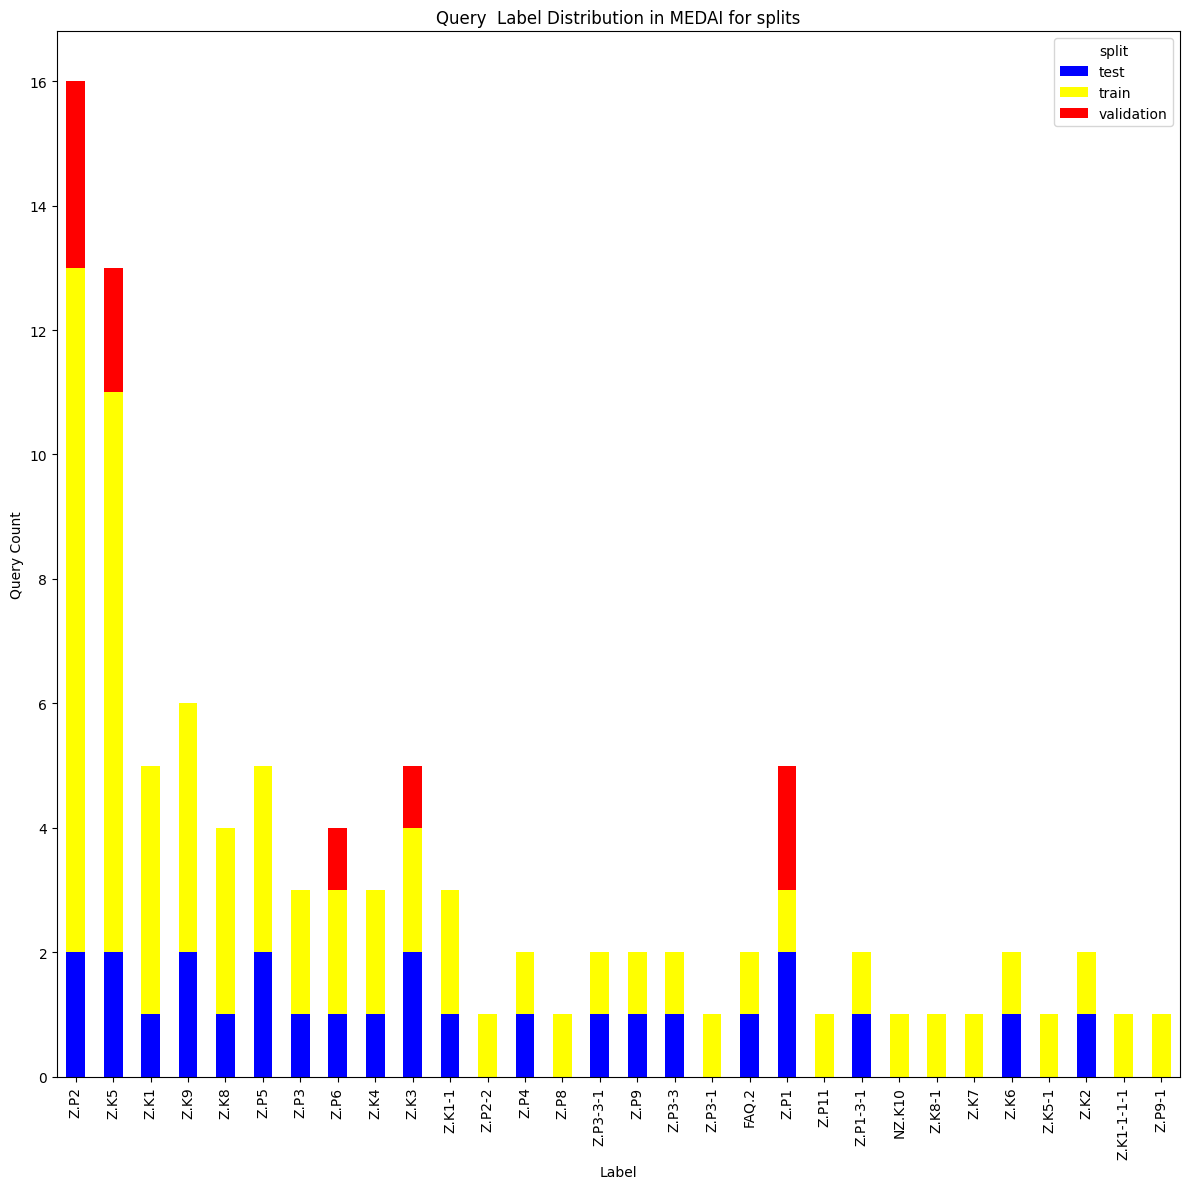

split,test,train,validation
label,,,
Z.P1-1,4.0,30.0,6.0
Z.P1,4.0,21.0,3.0
Z.P2,1.0,15.0,5.0
Z.K2,3.0,14.0,2.0
Z.K14,1.0,13.0,2.0
Z.P4-1,4.0,13.0,4.0
Z.P8,3.0,12.0,1.0
NZ.K10,3.0,10.0,2.0
Z.P3,1.0,9.0,1.0


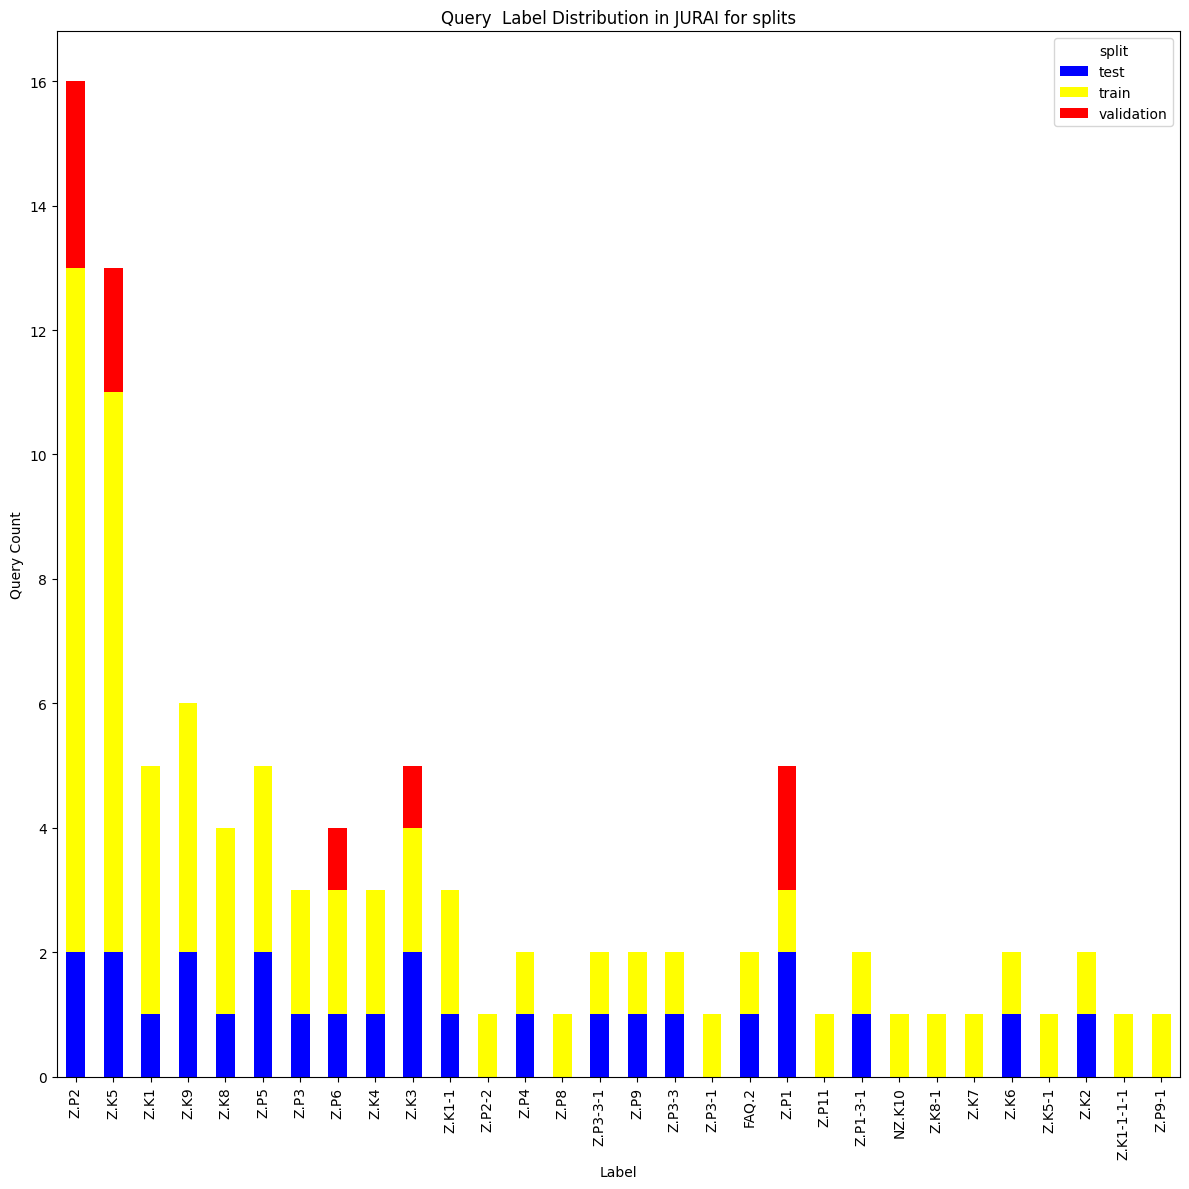

split,test,train,validation
label,,,
Z.P11,14.0,99.0,19.0
Z.P12,3.0,44.0,8.0
Z.C3,7.0,39.0,9.0
Z.P8-1-2,3.0,37.0,10.0
Z.C11,3.0,29.0,4.0
...,...,...,...
Z.C8,1.0,1.0,1.0
Z.P3,0.0,1.0,0.0
Z.C9,0.0,1.0,0.0


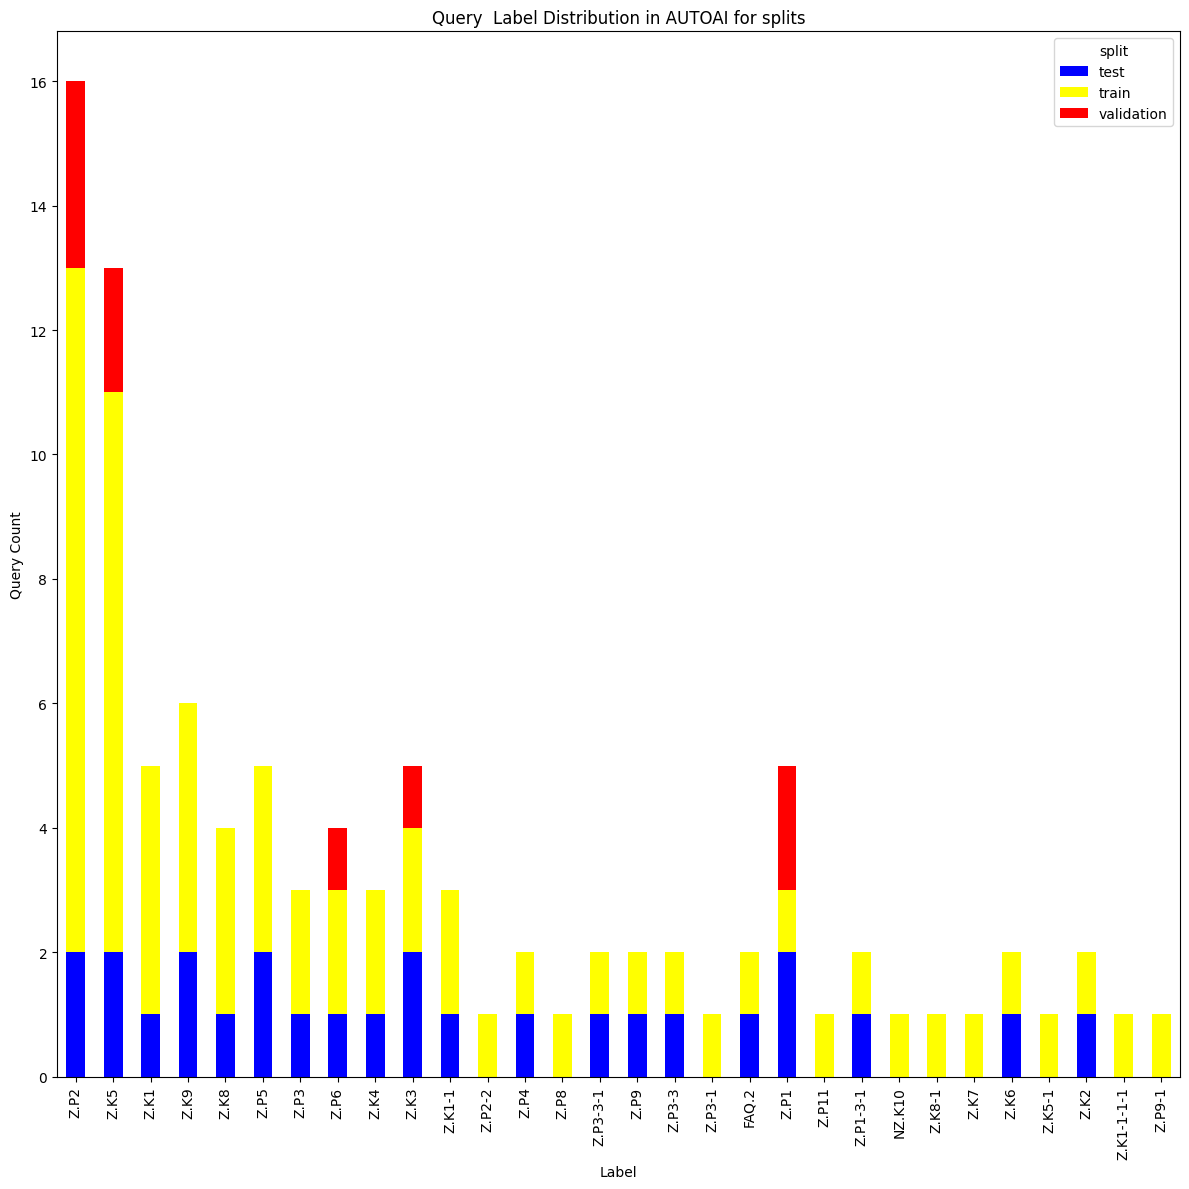

split,test,train,validation
label,,,
Z.P2,2.0,11.0,3.0
Z.K5,2.0,9.0,2.0
Z.K1,1.0,4.0,0.0
Z.K9,2.0,4.0,0.0
Z.K8,1.0,3.0,0.0
Z.P5,2.0,3.0,0.0
Z.P3,1.0,2.0,0.0
Z.P6,1.0,2.0,1.0
Z.K4,1.0,2.0,0.0


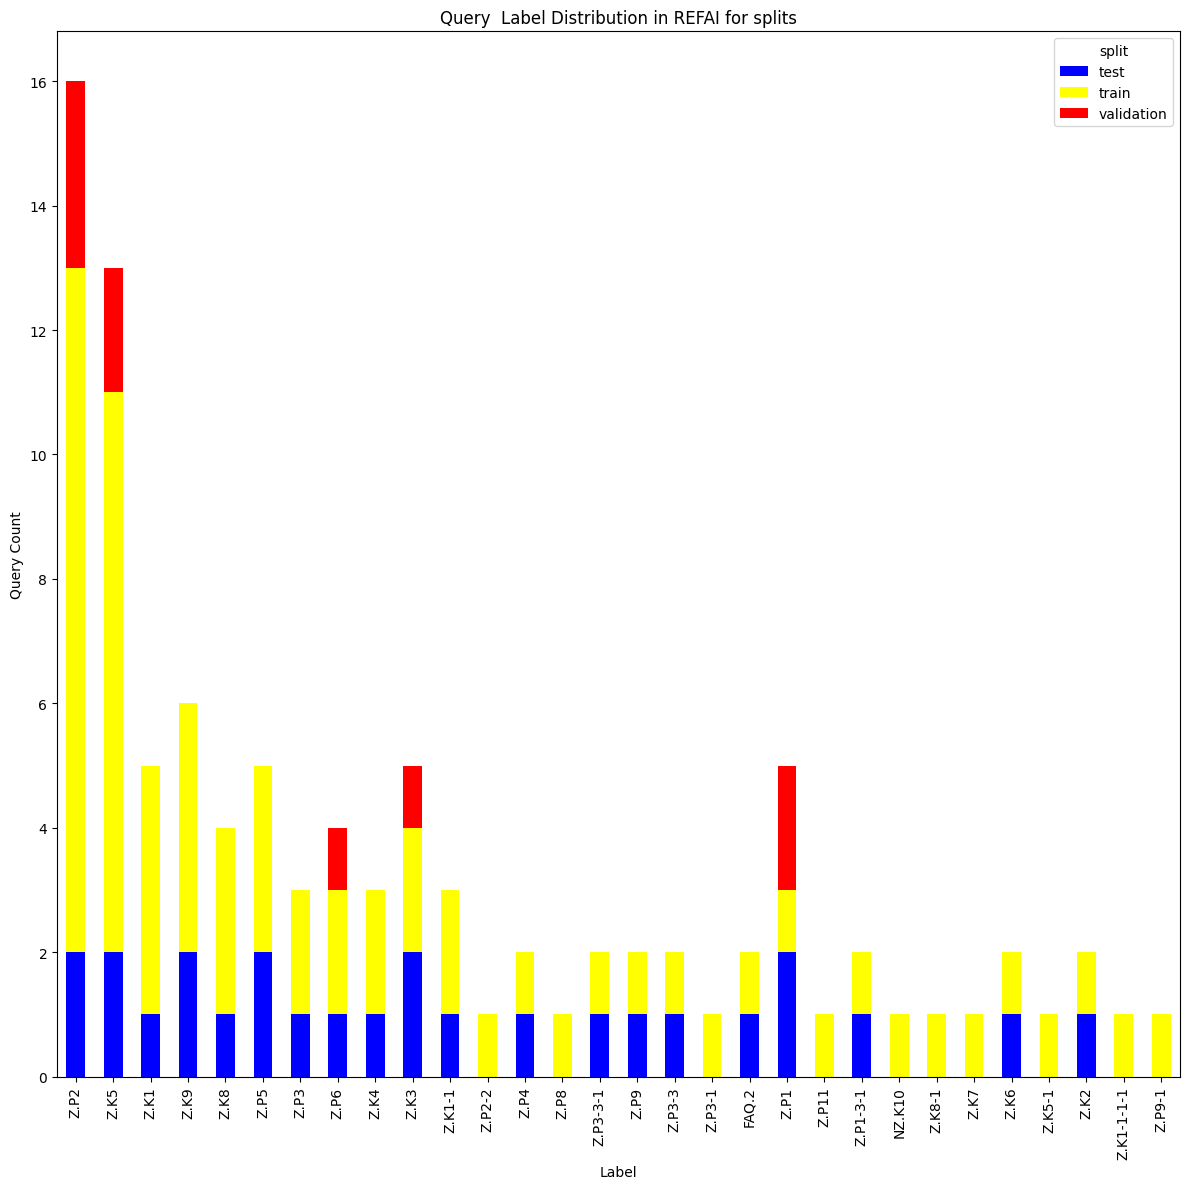

In [18]:
# Count labels per scenario and split for queries
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for query in in_distribution_split[split]["queries"]:
        scenario = query["discussion_scenario"]
        for label in query["labels"]:
            label_counts[split][scenario][label] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

query_scenario_split_label_counts_df = pd.DataFrame(records)
query_scenario_split_label_counts_df.to_csv("simple_split_label_num_queries_distribution.csv")
display(query_scenario_split_label_counts_df)

# Plot stacked bar chart per scenario
scenarios = query_scenario_split_label_counts_df["scenario"].unique()
for scenario in scenarios:
    df_scenario = query_scenario_split_label_counts_df[query_scenario_split_label_counts_df["scenario"] == scenario]
    query_scenario_split_label_counts_df_with_zero_counts = df_scenario.pivot(index="label", columns="split", values="count").fillna(0).sort_values("train", ascending=False)
    display(query_scenario_split_label_counts_df_with_zero_counts)
    query_scenario_split_label_counts_df_with_zero_counts.to_csv(f"simple_split_queries_counts_per_label_and_split_{scenario}.csv")
    query_scenario_split_label_counts_df_with_zero_counts.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 12))
    plt.title(f"Query  Label Distribution in {scenario} for splits")
    plt.ylabel("Query Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [13]:
def create_scenario_plots(df, output_dir="plots", show_all_ranks=True, dpi=300, x_label_interval=2):
    """
    Create one rank-frequency plot for each scenario showing all splits as grouped bar charts.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns: scenario, label, split, count
    output_dir : str
        Directory to save the plots
    show_all_ranks : bool
        If True, show all ranks; if False, limit to the split with the fewest labels
    dpi : int
        Resolution for the saved plots
    x_label_interval : int
        Show x-axis labels every nth rank (2=every second, 3=every third, etc.)

    Returns:
    --------
    filenames : list
        List of saved filenames
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import numpy as np

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.2)

    # Colors for splits
    split_colors = {
        'train': '#4CAF50',      # Green
        'validation': '#2196F3', # Blue
        'test': '#FF5722'        # Orange
    }

    # Get all scenarios
    scenarios = df['scenario'].unique()

    # List to store filenames
    filenames = []

    # Create one plot per scenario
    for scenario in scenarios:
        # Filter data for this scenario
        scenario_data = df[df['scenario'] == scenario].copy()

        # Process each split
        split_data = {}
        max_rank = 0

        for split in ['train', 'validation', 'test']:
            # Filter data for this split
            split_df = scenario_data[scenario_data['split'] == split].copy()

            # Skip if no data
            if split_df.empty:
                split_data[split] = pd.DataFrame(columns=['rank', 'count', 'label'])
                continue

            # Sort by count (descending) and add rank
            split_df = split_df.sort_values('count', ascending=False).reset_index(drop=True)
            split_df['rank'] = split_df.index + 1  # Ranks start at 1

            # Store the data
            split_data[split] = split_df

            # Track the maximum rank for x-axis limit
            max_rank = max(max_rank, len(split_df))

        # Determine how many ranks to show
        if not show_all_ranks:
            # Find the minimum number of ranks across all splits with data
            non_empty_splits = [len(data) for split, data in split_data.items()
                               if not data.empty]
            if non_empty_splits:  # Make sure we have at least one non-empty split
                max_rank = min(non_empty_splits)

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)

        # Set width of bars
        bar_width = 0.25

        # Create positions for each rank - making sure we start at rank 1
        bar_positions = np.arange(max_rank)  # 0-based array

        # Create the grouped bar chart
        for i, split in enumerate(['train', 'validation', 'test']):
            if split_data[split].empty:
                continue

            # For each split, get the ranks to plot (limited to max_rank)
            split_ranks = split_data[split][split_data[split]['rank'] <= max_rank]

            if split_ranks.empty:
                continue

            # Calculate position for this split (adjusting for grouped bars)
            # -bar_width, 0, +bar_width for the three splits
            position_adjust = (i - 1) * bar_width

            # Plot this split's bars
            bars = ax.bar(
                bar_positions[:len(split_ranks)] + position_adjust + 1,  # +1 to shift to ranks starting at 1
                split_ranks['count'].values,
                width=bar_width,
                color=split_colors[split],
                label=f"{split.capitalize()}",
                alpha=0.8,
                edgecolor='black',
                linewidth=0.5
            )

            # Add the label text above each bar
            if max_rank <= 15:  # Only add labels if not too crowded
                for j, bar in enumerate(bars):
                    height = bar.get_height()
                    if j < len(split_ranks):  # Make sure we have data for this index
                        label_text = split_ranks['label'].iloc[j]
                        # Truncate long labels
                        if len(label_text) > 10:
                            label_text = label_text[:8] + '..'

                        # Don't show label for very small bars
                        if height > 0.05 * ax.get_ylim()[1]:
                            ax.text(
                                bar.get_x() + bar.get_width()/2,
                                height + 0.01 * ax.get_ylim()[1],
                                label_text,
                                ha='center',
                                va='bottom',
                                rotation=90,
                                fontsize=8
                            )

        # Set the x-axis ticks at the center of each group of bars
        tick_positions = np.arange(1, max_rank + 1)  # Ranks start at 1
        tick_labels = [f"{r}" if r % x_label_interval == 1 or r == 1 else ""
                      for r in range(1, max_rank + 1)]

        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)

        # Set labels and title
        ax.set_xlabel('Label Rank', fontsize=12)
        ax.set_ylabel('Number of Queries', fontsize=12)
        # ax.set_title(f'{scenario} - Rank-Frequency Distribution by Split', fontsize=14)

        # Add grid and clean up spines
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')  # Only horizontal grid lines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add legend
        ax.legend(frameon=True, framealpha=0.9, loc='upper right')

        # Ensure y-axis starts at 0
        ax.set_ylim(bottom=0)

        # Set x-axis limits to ensure proper display of all bars including rank 1
        ax.set_xlim(0.5, max_rank + 0.5)


        # Print debug info for first 5 ranks
        for split in ['train', 'validation', 'test']:
            if not split_data[split].empty and len(split_data[split]) > 0:
                first_ranks = split_data[split].head(5)
                print(f"DEBUG - {scenario} - {split} - First 5 ranks:")
                print(first_ranks[['rank', 'count', 'label']])

        # Save the plot in EPS format
        file_format = "eps"
        filename = os.path.join(output_dir, f"{scenario}_rank_frequency.{file_format}")
        plt.tight_layout()
        plt.savefig(filename, format=file_format)
        plt.close()

        filenames.append(filename)

    return filenames

# create_scenario_plots(df, output_dir="../../reports/dataset_statistics/corpus_dataset_v2/in_distribution_split", show_all_ranks=True, dpi=300)



In [39]:
def get_max_counts(data):
    max_counts = {}
    for scenario, splits in data.items():
        max_count = 0
        for split in splits.values():
            split_max = max(split.values(), default=0)
            max_count = max(max_count, split_max)
        max_counts[scenario] = max_count
    return max_counts

topic_split_label_counts = None
topic_split_label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for scenario in query_scenario_split_label_counts_df["scenario"].unique():
    pivot_df = query_scenario_split_label_counts_df[query_scenario_split_label_counts_df["scenario"] == scenario].pivot(index="label", columns="split", values="count").fillna(0)
    for idx, row in pivot_df.iterrows():
        topic_split_label_counts[scenario]["test"][row.name] = row["test"]
        topic_split_label_counts[scenario]["validation"][row.name] = row["validation"]
        topic_split_label_counts[scenario]["train"][row.name] = row["train"]
        # print(row.name)


topic_split_label_counts


defaultdict(<function __main__.<lambda>()>,
            {'MEDAI': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'test': defaultdict(int,
                                      {'FAQ.1': 1.0,
                                       'FAQ.2': 2.0,
                                       'FAQ.3': 2.0,
                                       'FAQ.5': 1.0,
                                       'FAQ.6': 1.0,
                                       'FAQ.7': 2.0,
                                       'FAQ.8': 2.0,
                                       'NZ.K1': 0.0,
                                       'NZ.K10': 23.0,
                                       'NZ.K11': 2.0,
                                       'NZ.K3': 2.0,
                                       'NZ.K4': 1.0,
                                       'NZ.K6': 1.0,
                                       'NZ.K8': 4.0,
                                       'NZ.K9': 3.0,
                       

/tmp/ipykernel_26413/228481487.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


256.0
32.0


/tmp/ipykernel_26413/228481487.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_26413/228481487.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


128.0
16.0


/tmp/ipykernel_26413/228481487.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


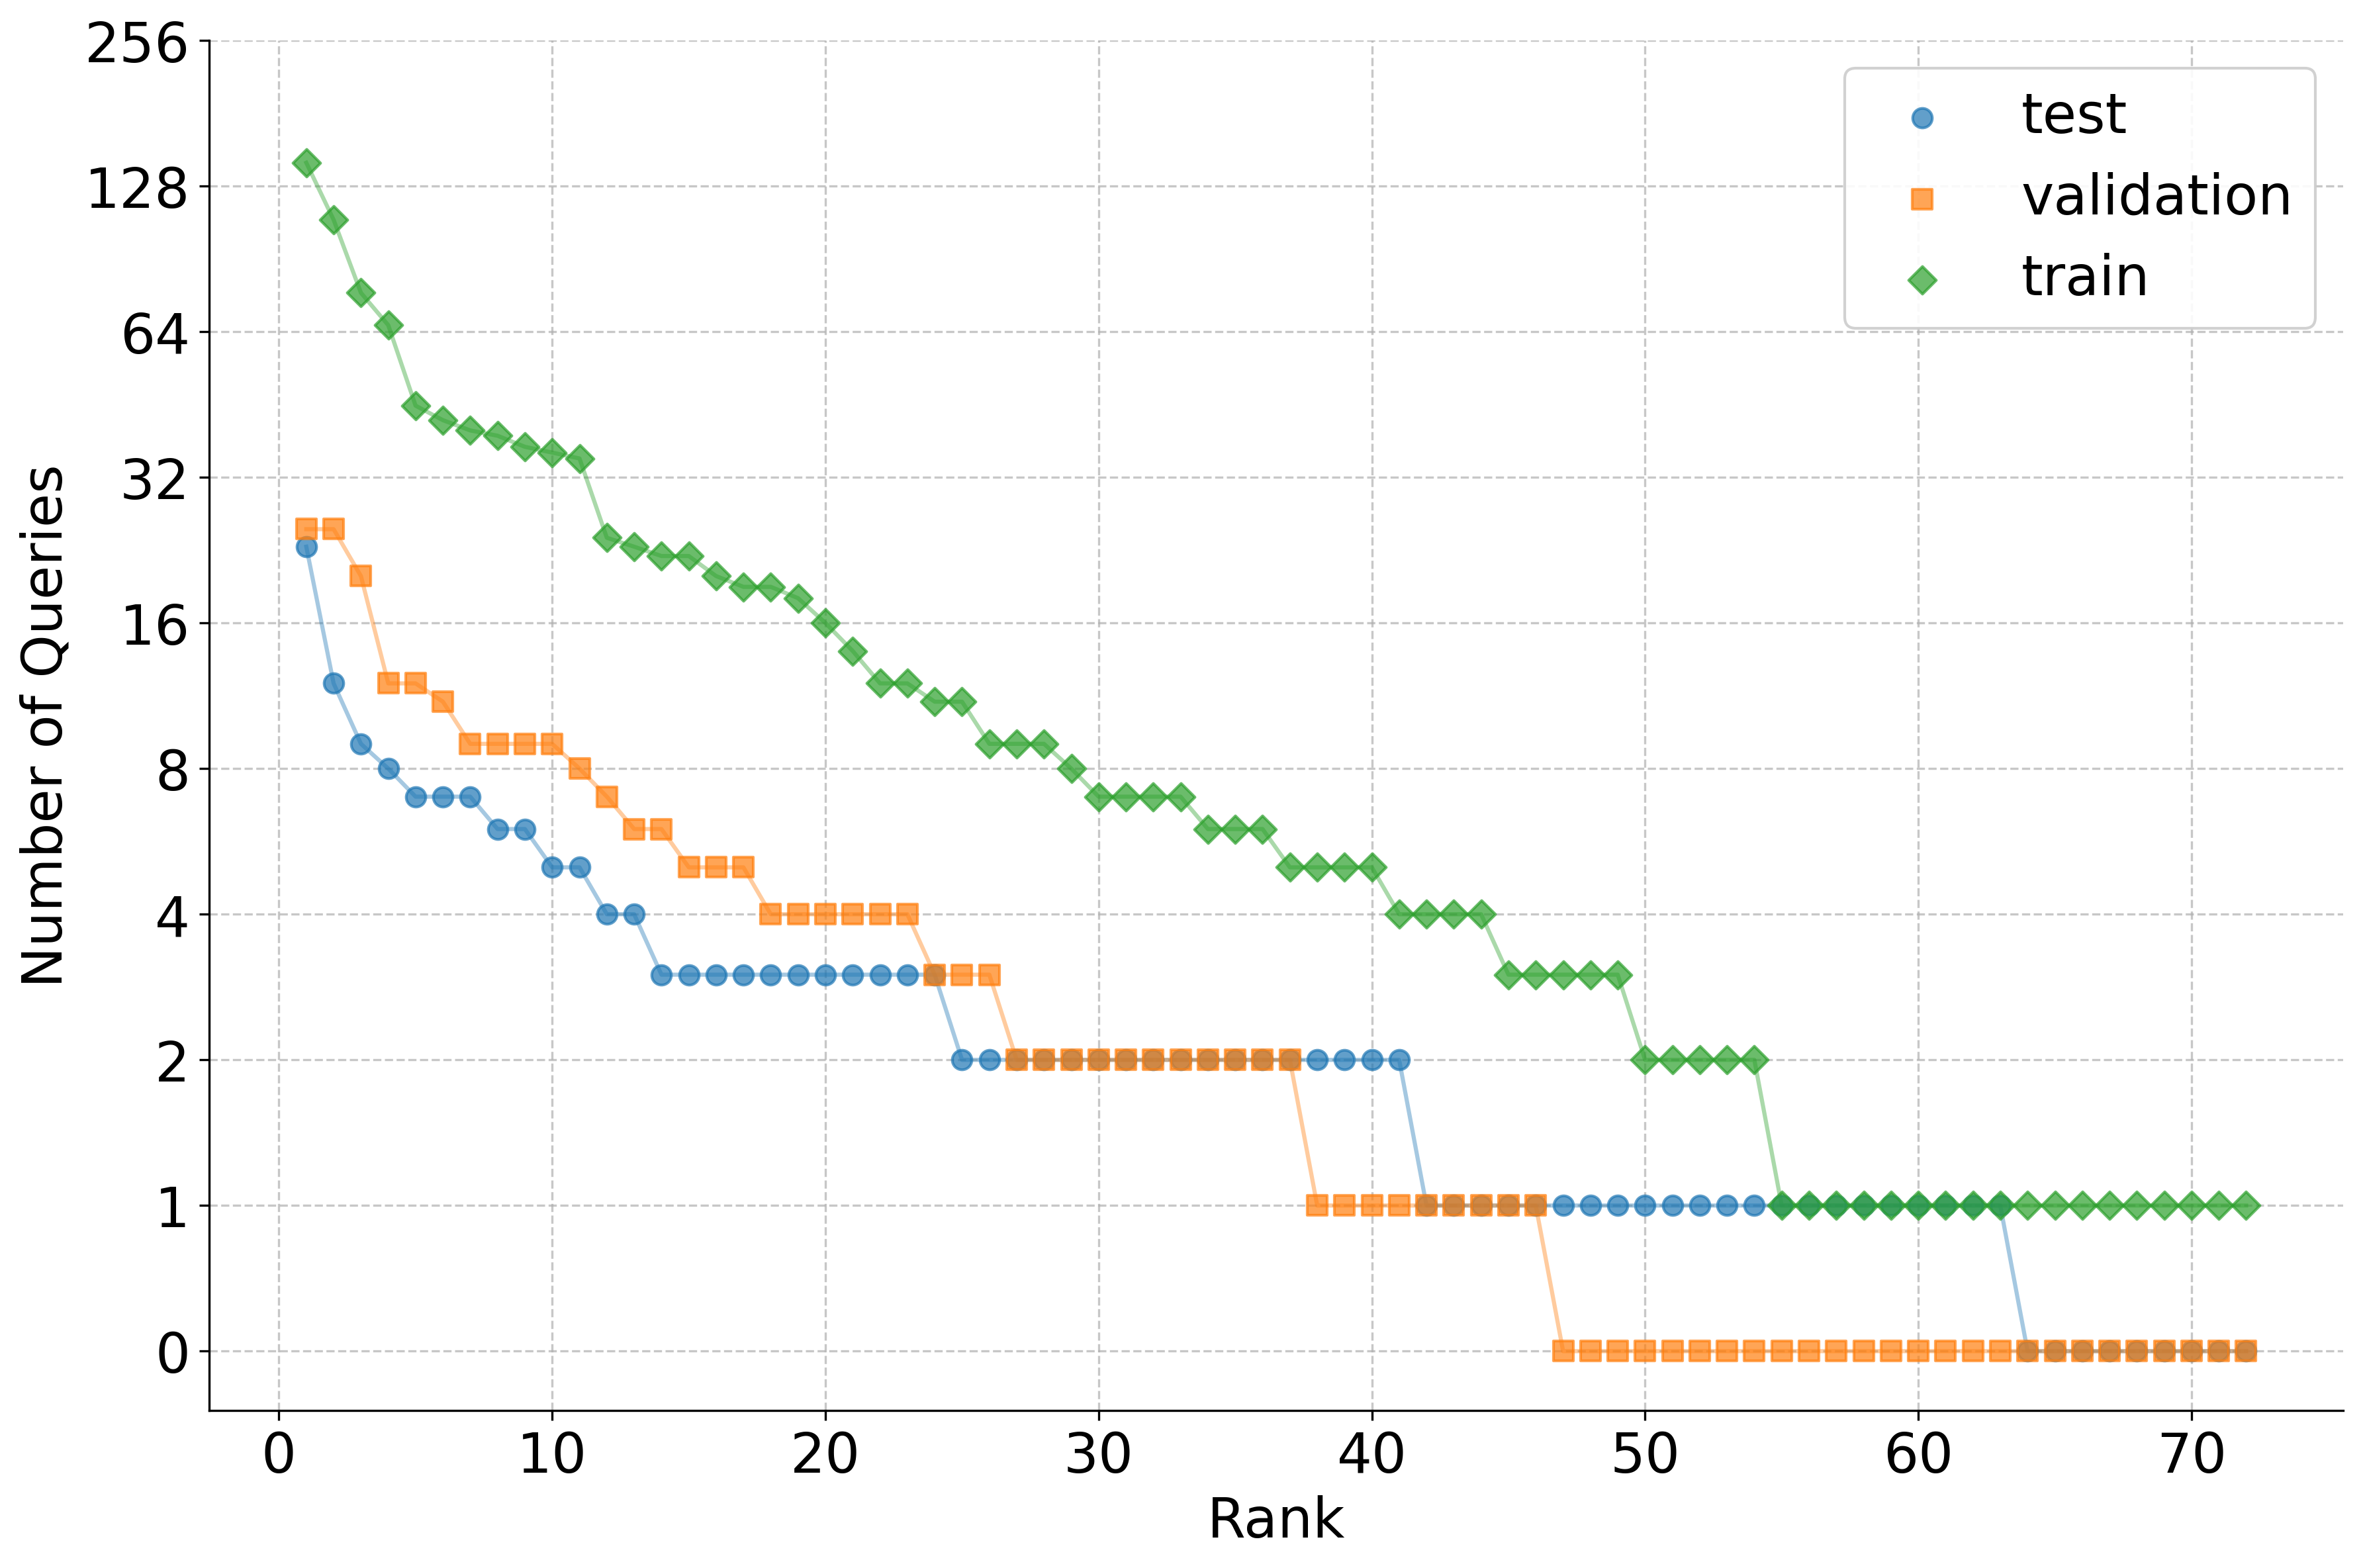

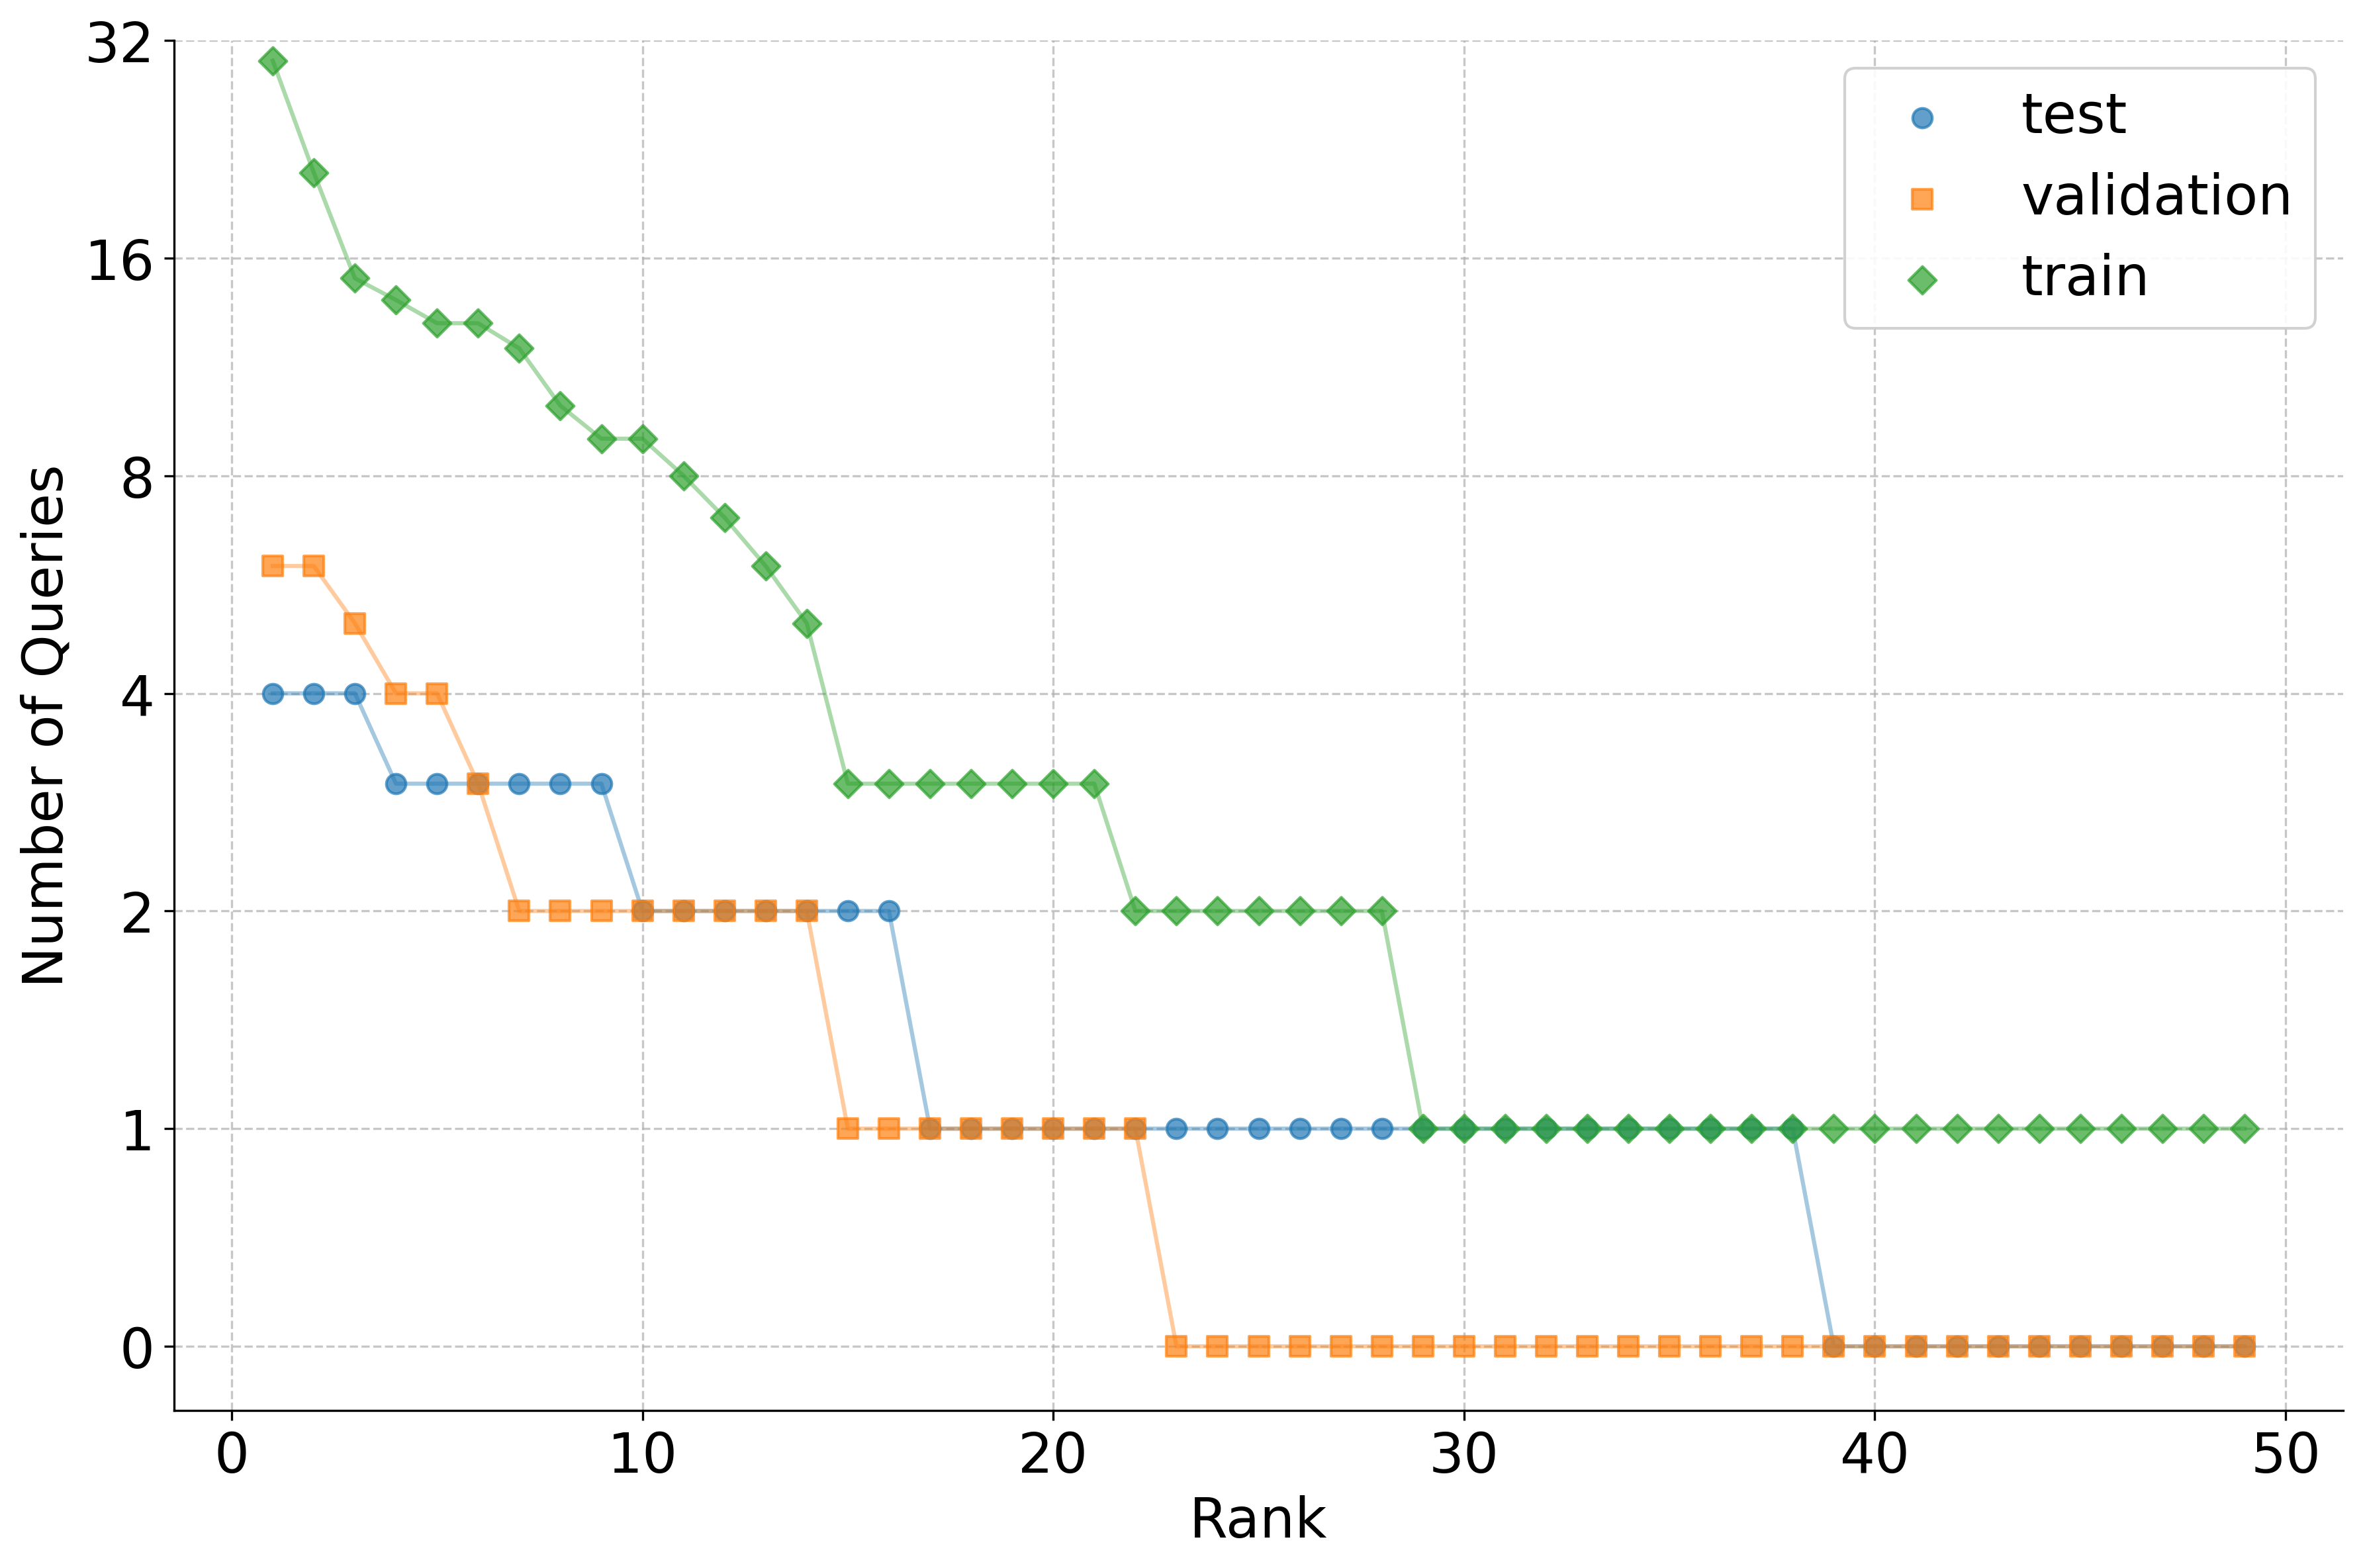

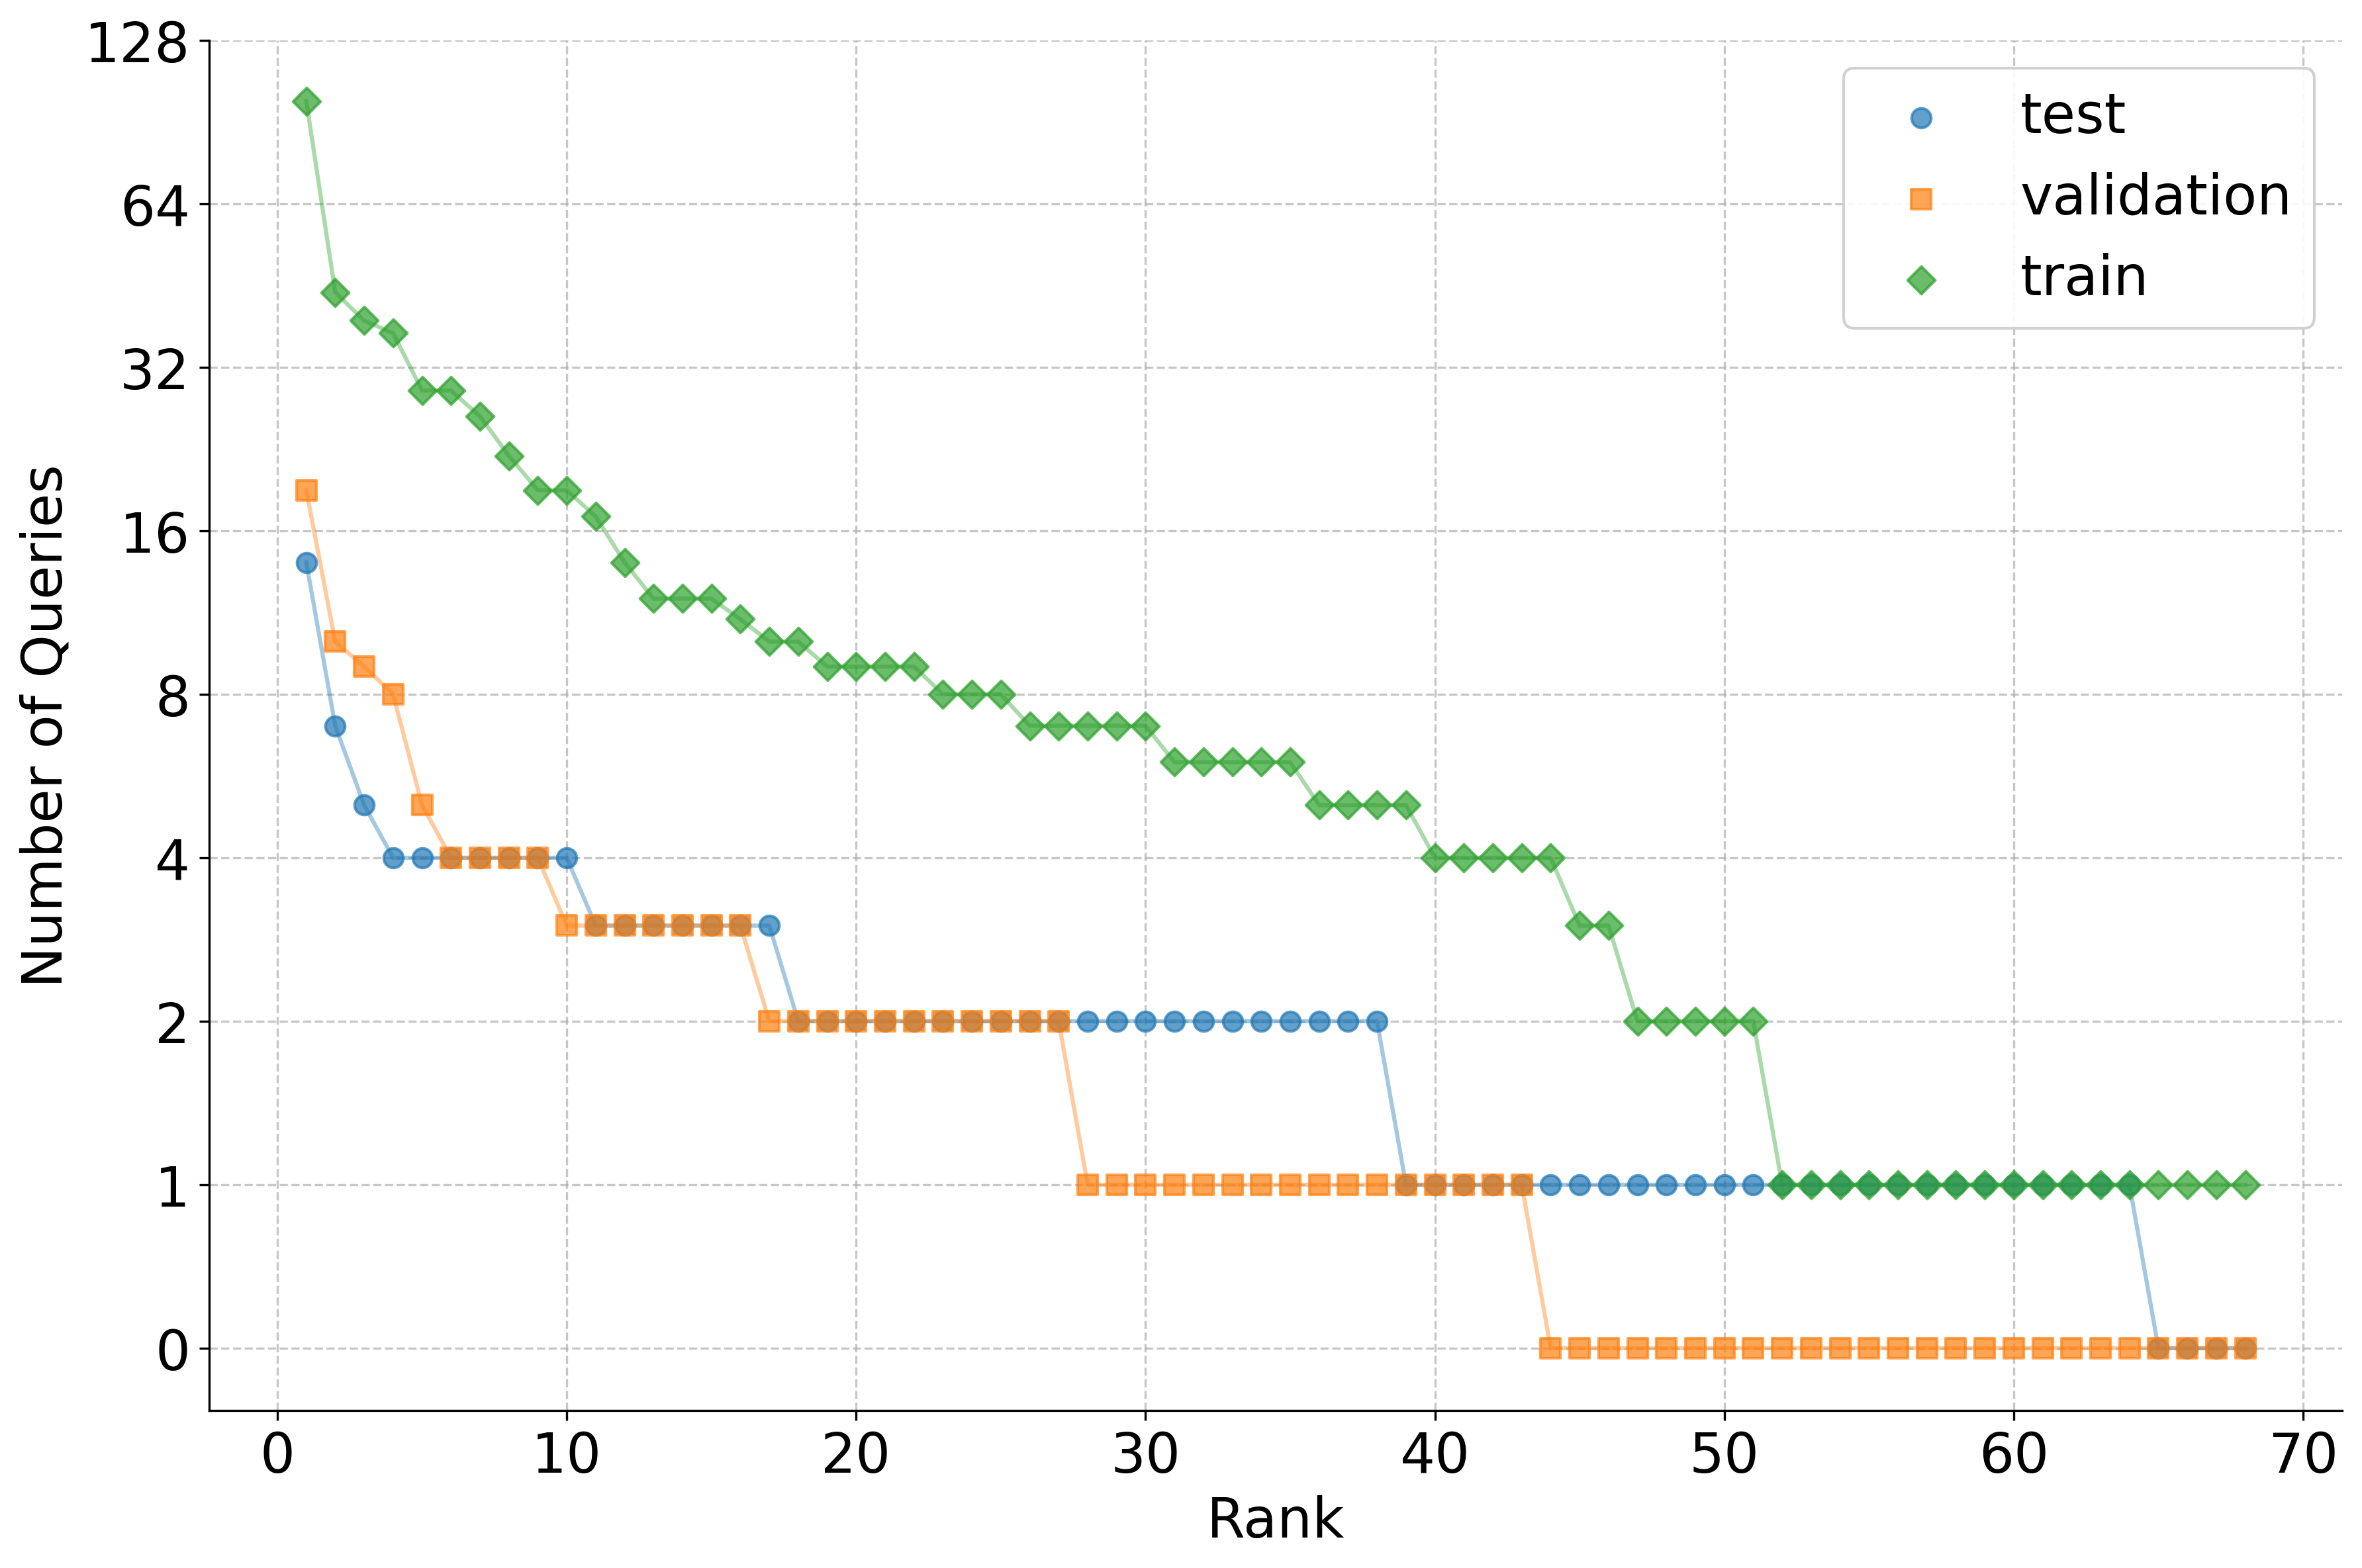

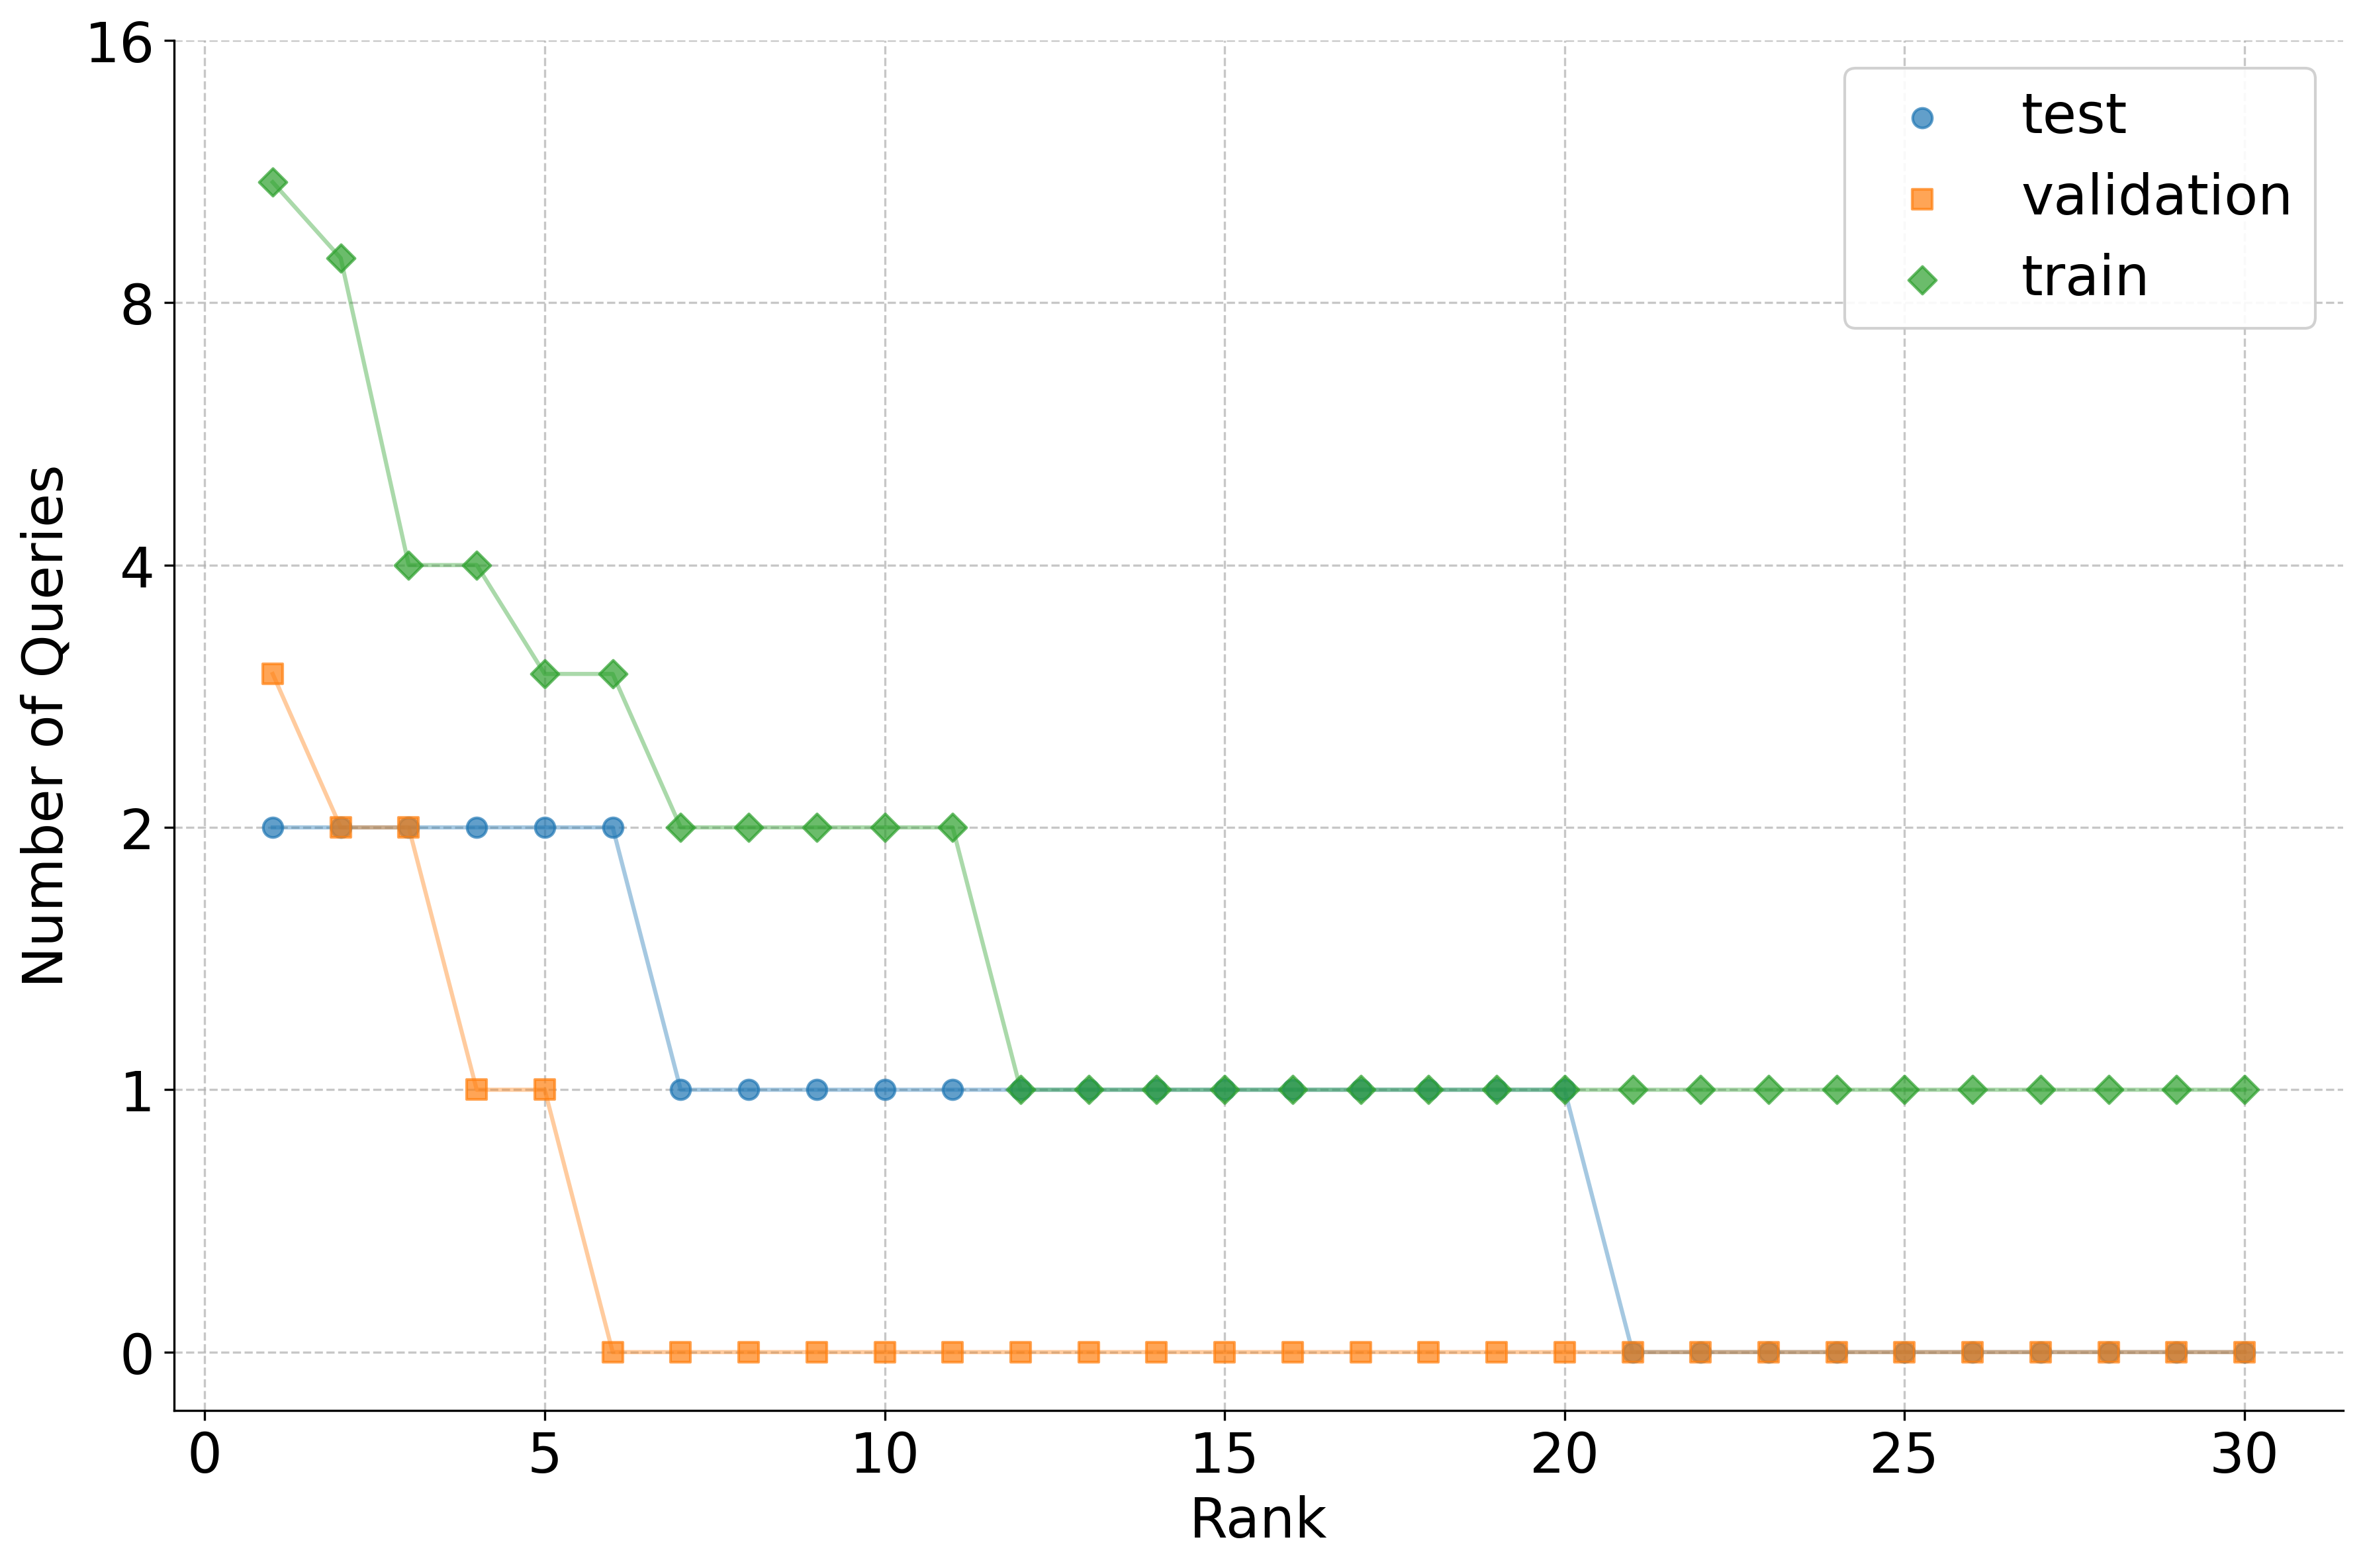

In [50]:
import numpy as np
from src.statistics.helper_functions import create_combined_rank_frequency_plot

output_dir="../../reports/dataset_statistics/corpus_dataset_v2/in_distribution_split"

topic_max_counts = get_max_counts(topic_split_label_counts)
for scenario in topic_split_label_counts.keys():
    max_count = topic_max_counts[scenario]
    y_max = np.exp2(int(np.log2(max_count)) + 1)
    print(y_max)
    fig, ax = create_combined_rank_frequency_plot(
        topic_split_label_counts[scenario],
        figsize=(12, 8),
        ylabel='Number of Queries',
        # yticks=[0, 1, 2, 4, 8, 16, 32, 64, 128],
        log_y="symlog",
        linthresh=1,
        y_max=y_max
    )
    fig.show()
    # For better visualization of the long tail
    # ax.set_xlim(0, 50)  # Focus on first 50 ranks
    plt.savefig(f'{output_dir}/rank_frequency_linear_{scenario}.eps', format="eps")



split,test,train,validation
label,,,
Z.K3-1-1,23,23,23
Z.K3-2,22,22,22
Z.K11-1,22,22,22
FAQ.4,22,22,22
Z.K19-1,22,22,22


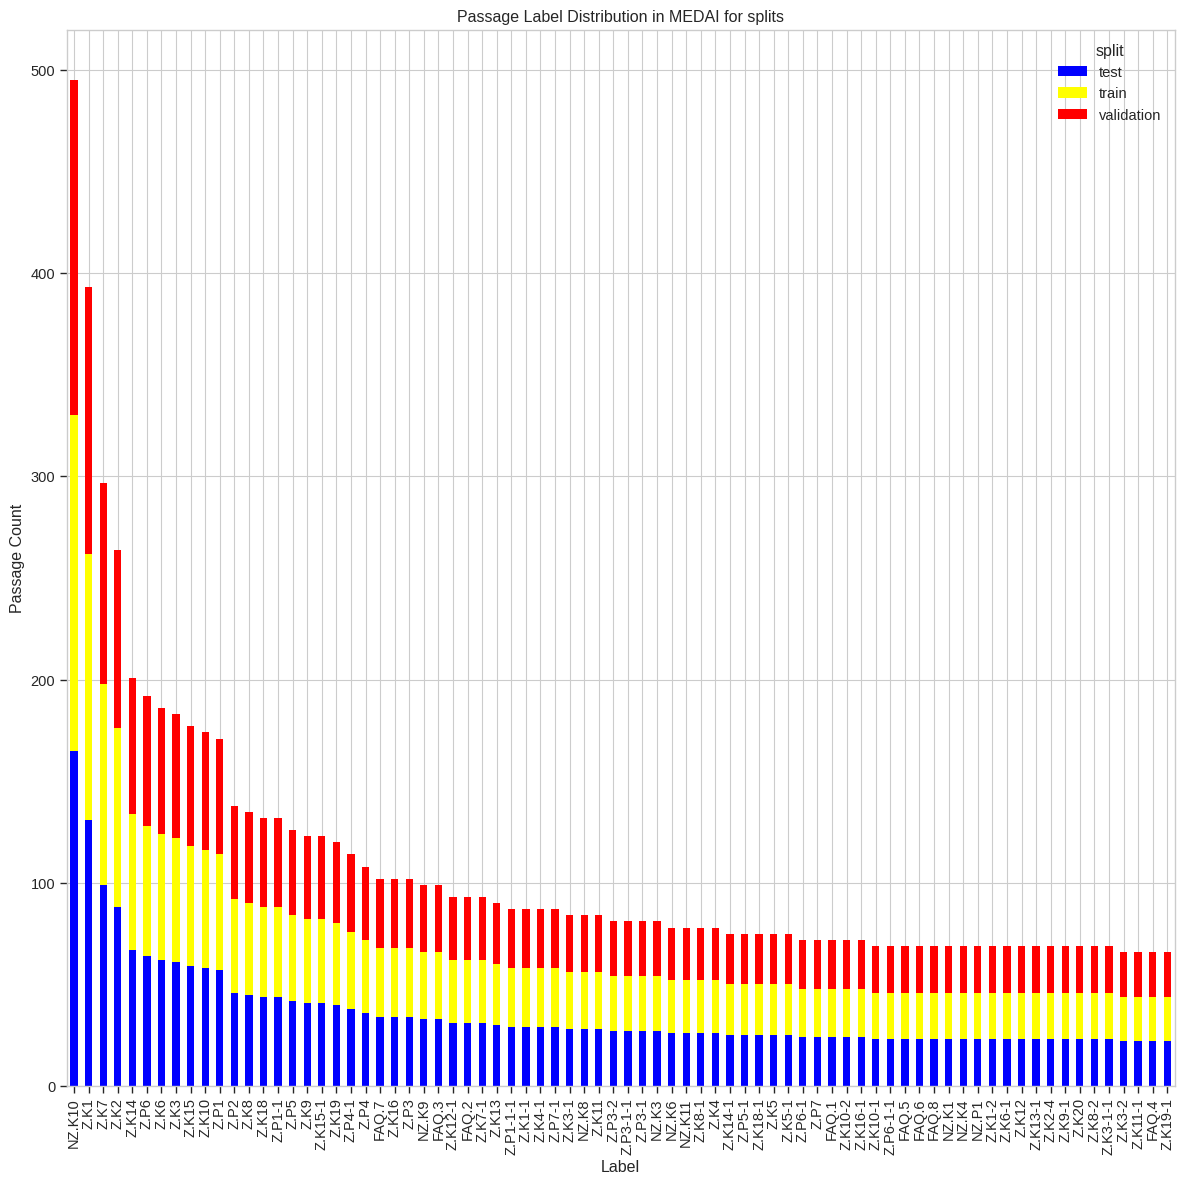

split,test,train,validation
label,,,
NZ.K1,22,22,22
Z.K13,22,22,22
Z.P2-2-1,22,22,22
Z.K14-1,22,22,22
Z.K15-1,22,22,22


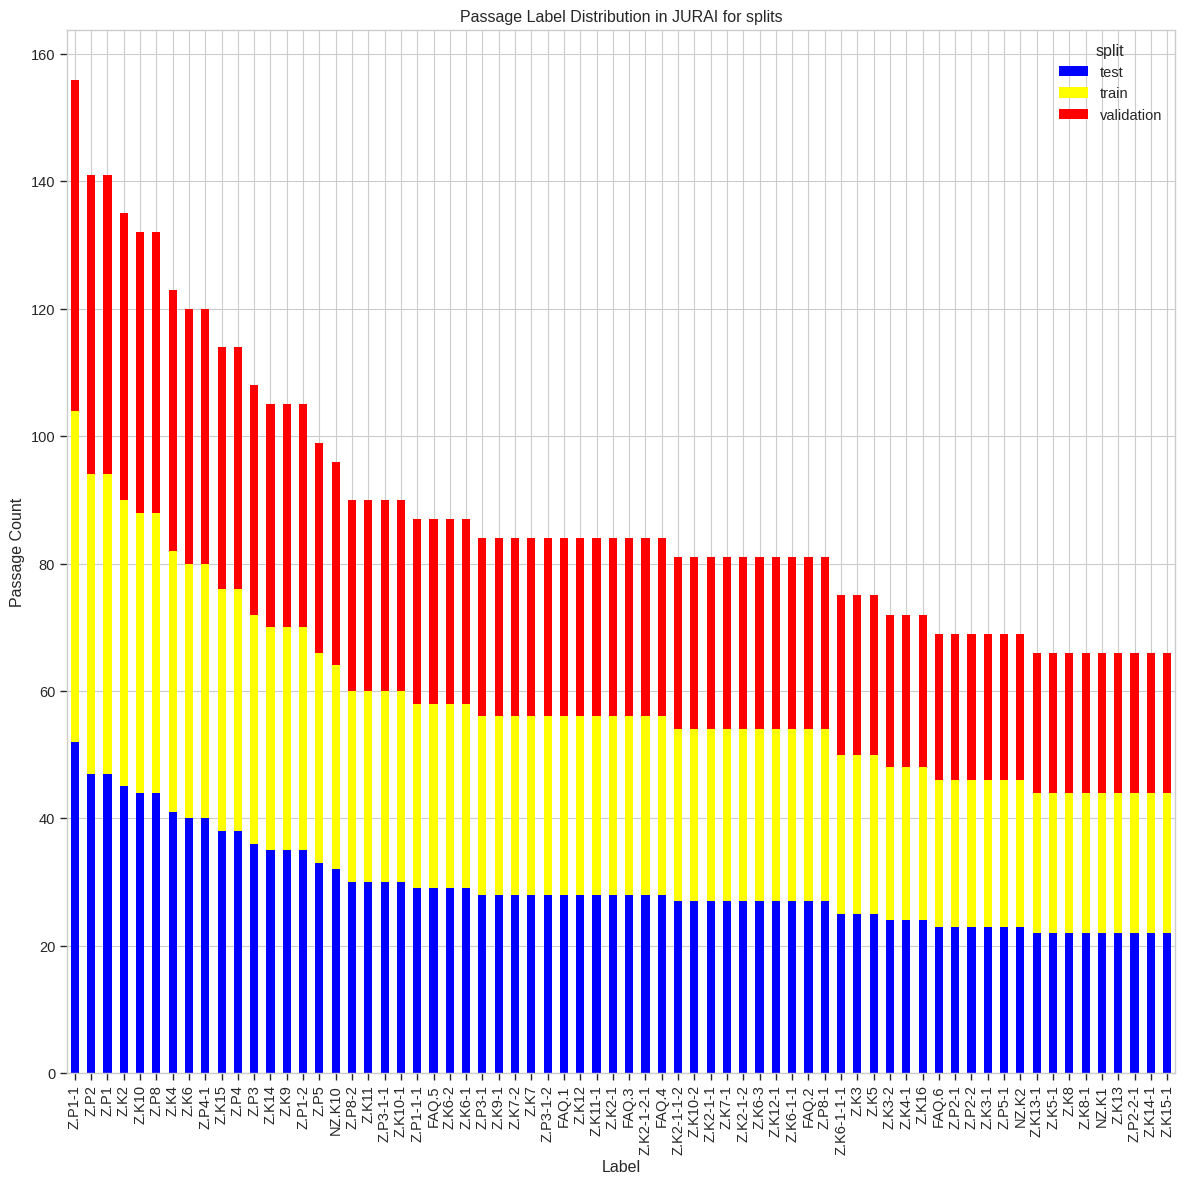

split,test,train,validation
label,,,
Z.C13,23,23,23
Z.P15-1,22,22,22
Z.C12-1,22,22,22
FAQ.2,22,22,22
FAQ.1,22,22,22


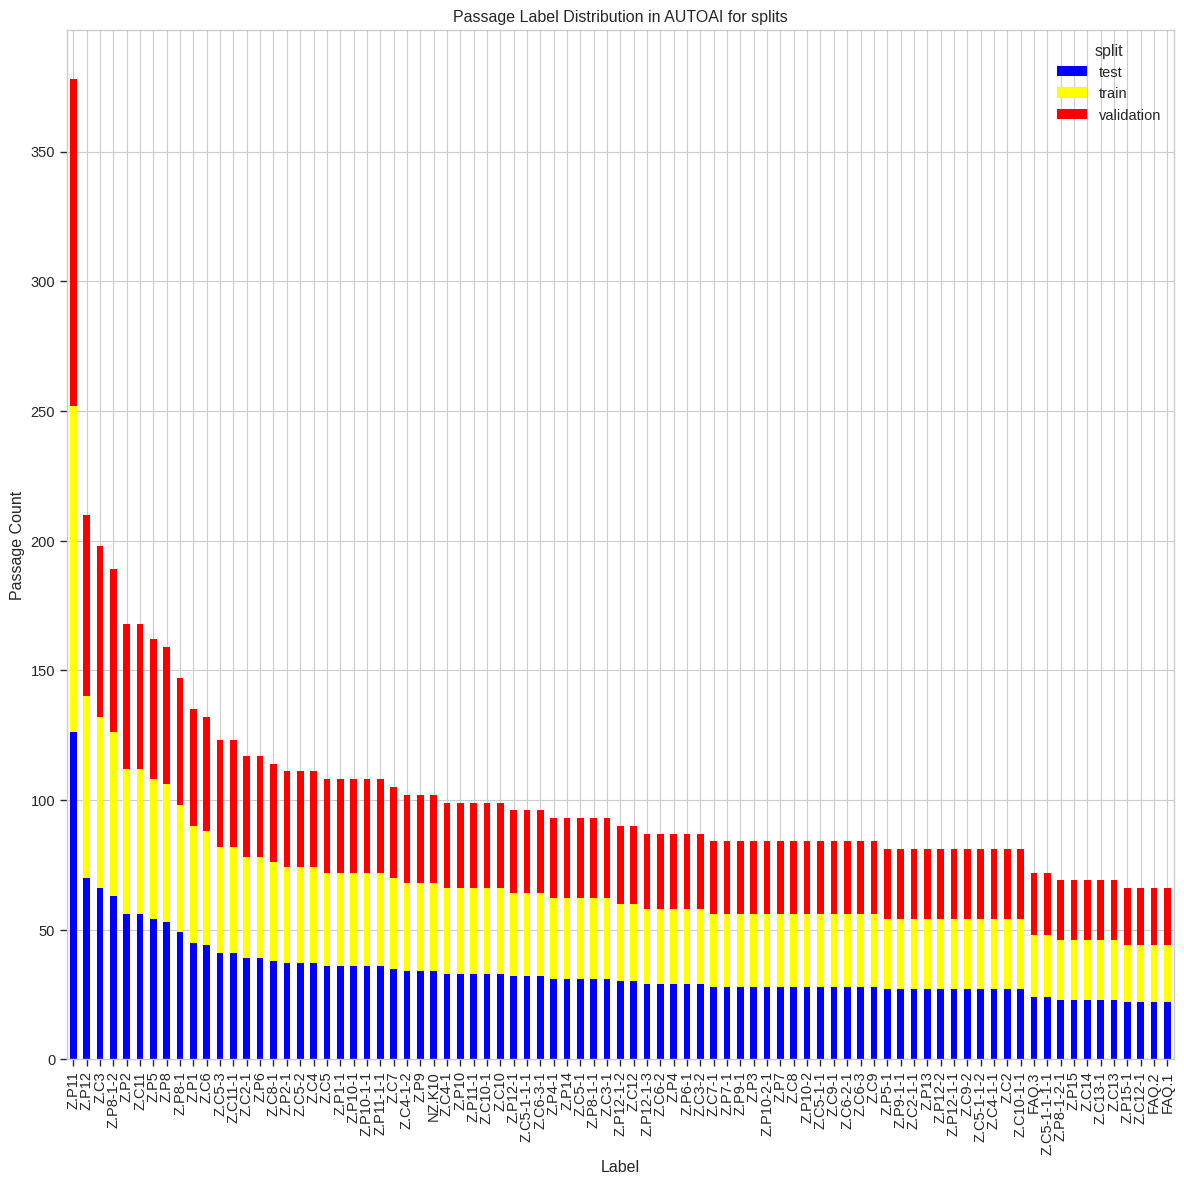

split,test,train,validation
label,,,
Z.K9-2,22,22,22
Z.P-4-1-1,22,22,22
Z.P1-2,22,22,22
Z.P1-3,22,22,22
Z.P9-2,22,22,22


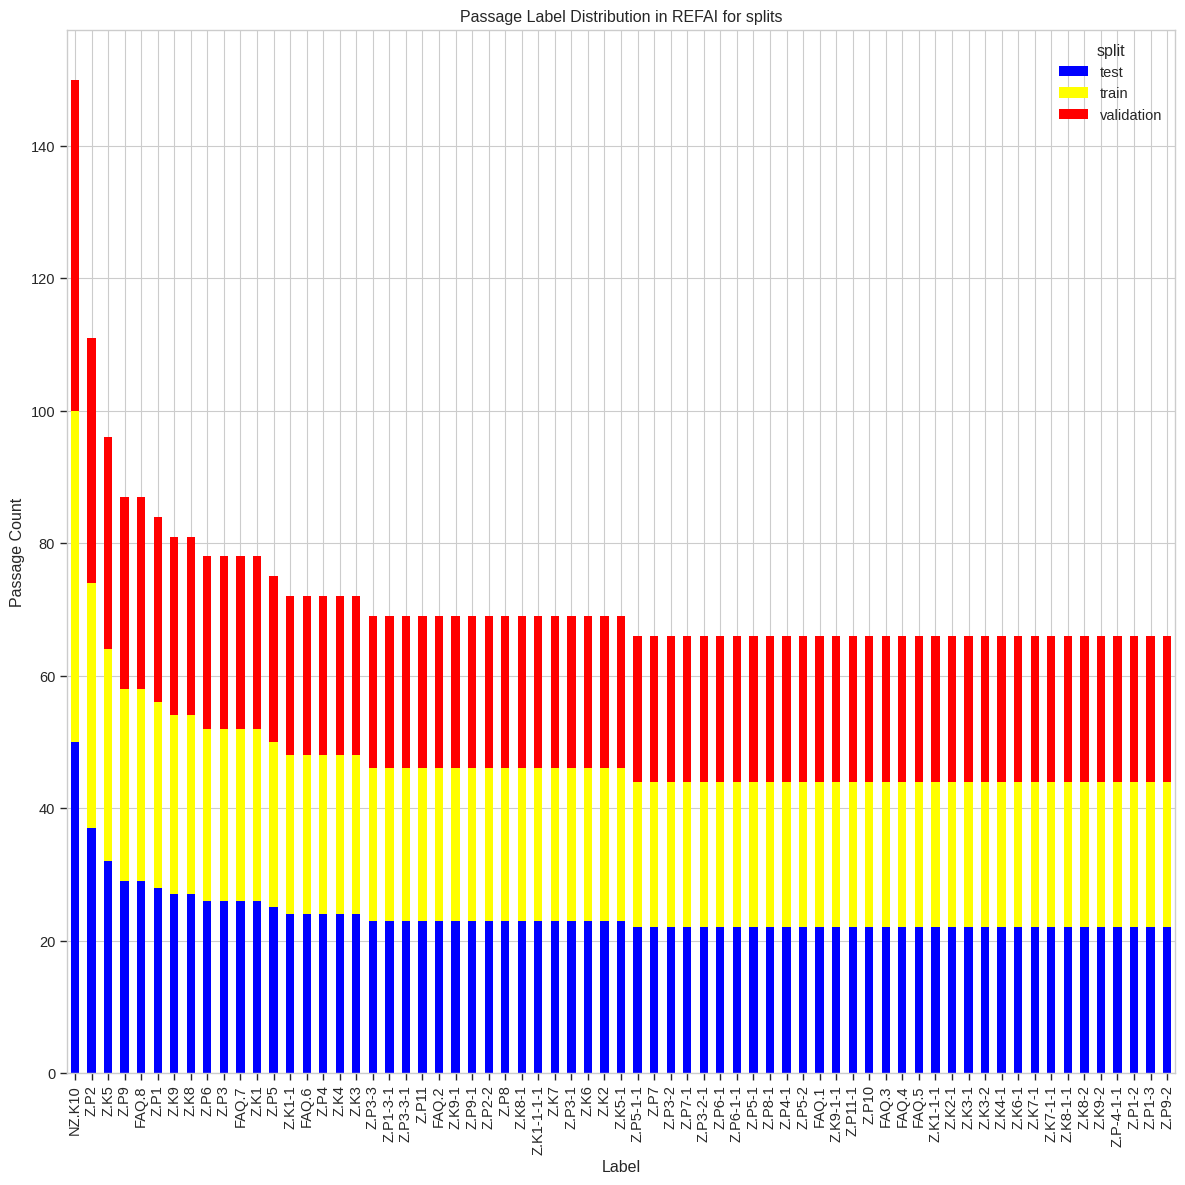

In [14]:
# Count labels per scenario and split for passages
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for passage in in_distribution_split[split]["passages"]:
        scenario = passage["discussion_scenario"]
        label_counts[split][scenario][passage["label"]] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

df = pd.DataFrame(records)

# Plot stacked bar chart per scenario
scenarios = df["scenario"].unique()
for scenario in scenarios:
    df_scenario = df[df["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0).sort_values("test", ascending=False)
    display(pivot_df.tail())
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 12))
    plt.title(f"Passage Label Distribution in {scenario} for splits")
    plt.ylabel("Passage Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [15]:
def check_label_distribution(df):
    """
    Checks that any (scenario, label) pair found in 'validation' or 'test'
    also exists in 'train'. If not, prints out the faulty scenario-label pairs.
    Otherwise, confirms that the distribution is valid.
    """
    # Get all (scenario, label) pairs that appear in train (count > 0)
    train_pairs = df[(df["split"] == "train") & (df["count"] > 0)][["scenario", "label"]]
    allowed_pairs = set(zip(train_pairs["scenario"], train_pairs["label"]))

    # Find all pairs in validation/test that have count > 0
    non_train = df[df["split"].isin(["validation", "test"]) & (df["count"] > 0)].copy()

    # Mark which of these are allowed
    non_train["is_allowed"] = non_train.apply(
        lambda row: (row["scenario"], row["label"]) in allowed_pairs, axis=1
    )

    # Collect the ones that are not allowed
    faulty = non_train[~non_train["is_allowed"]]

    if len(faulty) > 0:
        print("Found scenario/label pairs in test/validation that do not appear in train:")
        print(faulty[["scenario", "label", "split", "count"]])
    else:
        print("All scenario/label pairs in test and validation are valid (they appear in train).")

check_label_distribution(df)




All scenario/label pairs in test and validation are valid (they appear in train).
